# Read Sub Demographic Data

In [0]:
from pyspark.sql.types import *

import pyspark.sql.functions as F

from pyspark import SparkContext
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("my project 2")\
    .config("spark.kryoserializer.buffer.max", "512m")\
    .config('spark.jars.packages', 'org.apache.spark:spark-sql-kafka-0-10_2.12:3.2.0')\
        .getOrCreate()
sc = spark.sparkContext


for_students_demo_path = "/mnt/ddscoursedatastorage/ro/fwm-stb-data/proj_B_demographic"
demographic_df = spark.read.parquet(for_students_demo_path).cache()
#display(demographic_df)

In [0]:
demographic_df.count()

Out[2]: 357721

##Feature Extraction

In [0]:
from pyspark.sql.functions import *

In [0]:
# calculatig the maximum household size of household in the data
max_household_size = demographic_df.select(max("household_size")).first()[0]

# calculatig the maximum num adults of household in the data
max_num_adults = demographic_df.select(max("num_adults")).first()[0]

# calculatig the maximum num generations of household in the data
max_num_generations = demographic_df.select(max("num_generations")).first()[0]

# calculatig the maximum length residence of household in the data
max_length_residence = demographic_df.select(max("length_residence")).first()[0]

# calculatig the maximum home market value of household in the data
max_home_market_value = demographic_df.select(max("home_market_value")).first()[0]

# calculatig the maximum net worth of household in the data
max_net_worth = demographic_df.select(max("net_worth")).first()[0]

# calculating the maximum education highest of household in the data
demographic_df = demographic_df.withColumn("education_highest", demographic_df.education_highest.cast(DoubleType())).cache()
max_education_highest = demographic_df.select(max("education_highest")).first()[0]

In [0]:
#Normalizing the required columns
demographic_df_normalized = demographic_df.withColumn('household_size', (col('household_size')/max_household_size))\
                                          .withColumn('num_adults', (col('num_adults')/max_num_adults))\
                                          .withColumn('num_generations', (col('num_generations')/max_num_generations))\
                                          .withColumn('length_residence', (col('length_residence')/max_length_residence))\
                                          .withColumn('home_market_value', (col('home_market_value')/max_home_market_value))\
                                          .withColumn('net_worth', (col('net_worth')/max_net_worth))\
                                          .withColumn("education_highest", (col('education_highest')/max_education_highest))\
                                          .cache()
demographic_df.unpersist()

Out[5]: DataFrame[household_id: bigint, household_size: int, num_adults: int, num_generations: int, marital_status: string, race_code: string, dwelling_type: string, home_owner_status: string, length_residence: int, home_market_value: double, net_worth: double, gender_individual: string, education_highest: double]

In [0]:
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

In [0]:
demographic_df_encoded = demographic_df_normalized.cache()
# List of categorical columns to index later and than present them as a feature vector
categorical_columns = ["marital_status", "race_code", "dwelling_type", "home_owner_status", "gender_individual"]
# Indexing each categorical column and insert the indexed values as a new column with an 'index' suffix in its name
indexed_columns = [column + "_index" for column in categorical_columns]

indexers = [StringIndexer(inputCol=column,
                          outputCol=column + "_index") for column in categorical_columns]
# Representing the categorical indexed columns as a feature vector                           
one_hot_encoders = [OneHotEncoder(inputCol=column + "_index",
                                  outputCol=column + "_encoded") for column in categorical_columns]
# Making sure all actions happen in the required order
encoding_pipeline = Pipeline(stages=indexers + one_hot_encoders)
model = encoding_pipeline.fit(demographic_df_encoded)
demographic_df_encoded = model.transform(demographic_df_encoded).cache()

# Dropping unused columns to make running time more efficient
demographic_df_encoded = demographic_df_encoded.drop(*(categorical_columns + indexed_columns)).cache()

demographic_df_encoded.show()

+------------+------------------+-------------------+------------------+------------------+-----------------+---------+-----------------+----------------------+-----------------+---------------------+-------------------------+-------------------------+
|household_id|    household_size|         num_adults|   num_generations|  length_residence|home_market_value|net_worth|education_highest|marital_status_encoded|race_code_encoded|dwelling_type_encoded|home_owner_status_encoded|gender_individual_encoded|
+------------+------------------+-------------------+------------------+------------------+-----------------+---------+-----------------+----------------------+-----------------+---------------------+-------------------------+-------------------------+
|          85|0.2222222222222222|0.16666666666666666|0.6666666666666666|               1.0|            0.125|     0.05|             0.25|             (3,[],[])|    (3,[0],[1.0])|        (1,[0],[1.0])|            (1,[0],[1.0])|               

In [0]:
from pyspark.ml.feature import VectorAssembler

# assigning
demographic_df_feature_vector = demographic_df_encoded.cache()
demographic_df_encoded.unpersist()

# the columns needed to be presented in the feature vector later
fields = demographic_df_feature_vector.drop("household_id").columns

# Representing the fields (specified above) as a feature vector                           
assembler = VectorAssembler(
    inputCols=fields,
    outputCol="features")

demographic_df_feature_vector = assembler.transform(demographic_df_feature_vector).cache()
demographic_df_feature_vector.select("household_id", "features").show(7, truncate=False)

+------------+--------------------------------------------------------------------------------------------------------------------------------+
|household_id|features                                                                                                                        |
+------------+--------------------------------------------------------------------------------------------------------------------------------+
|85          |[0.2222222222222222,0.16666666666666666,0.6666666666666666,1.0,0.125,0.05,0.25,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0]             |
|2073        |[0.1111111111111111,0.16666666666666666,0.6666666666666666,1.0,0.15,0.1,0.25,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0]               |
|2523        |[0.7777777777777778,1.0,1.0,1.0,0.1,0.1,0.5,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0]                                                |
|2717        |[0.3333333333333333,0.3333333333333333,0.6666666666666666,0.7333333333333333,0.125,0.2,0.75,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.

In [0]:
from pyspark.ml.functions import vector_to_array
from pyspark.ml.feature import PCA

# assigning
demographic_df_pca = demographic_df_feature_vector.cache()
demographic_df_feature_vector.unpersist()

# Reducting dimension of feature vector to 2
# Allows us to represent the data in a low dimensional representation with a good approximation of the original data 
pca = PCA().setInputCol("features")\
           .setOutputCol("pca")\
           .setK(2)
demographic_df_pca = pca.fit(demographic_df_pca).transform(demographic_df_pca).cache()

demographic_df_pca.select("household_id", "pca").show(7, truncate=False)

+------------+--------------------------------------------+
|household_id|pca                                         |
+------------+--------------------------------------------+
|85          |[-0.35625542326615856,-0.11097025338253631] |
|2073        |[-1.0925316168664254,0.12397733233143128]   |
|2523        |[-1.4149098090986307,-0.9701798366702089]   |
|2717        |[0.06329368821084108,-1.158369672110097]    |
|3364        |[-1.2929454215296108,-0.9714139901152653]   |
|4046        |[-1.1192228102668804,-0.0063753503650831895]|
|4303        |[0.07476265653874331,-1.1529793790408362]   |
+------------+--------------------------------------------+
only showing top 7 rows



In [0]:
# Separating the 2 components of the low dimensional representation of the feature vector to 2 different columns
demographic_df_pca = (demographic_df_pca
                        .withColumn("axis", vector_to_array("pca"))
                        .select(fields + [col("axis")[i] for i in range(2)])).cache()

/databricks/spark/python/pyspark/sql/pandas/conversion.py:119: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unable to convert the field marital_status_encoded. If this column is not necessary, you may consider dropping it or converting to primitive type before the conversion.
Direct cause: Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)
Out[41]: DataFrame[household_size: double, num_adults: double, num_generations: double, length_residence: double, home_market_value: double, net_worth: double, education_highest: double, marital_status_encoded: vector, race_code_encoded: vector, dwelling_type_encoded: vector, home_owner_status_encoded: vector, gender_individual_encoded: vector, x: double, y: double]

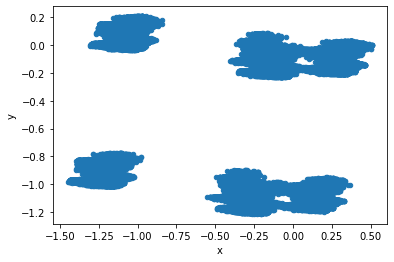

In [0]:
import pandas as pd

# Renaming the new 2 columns of the separated components of the pca result as x and y correspondingly
demographic_df_plot = demographic_df_pca.withColumnRenamed('axis[0]', 'x')\
                                        .withColumnRenamed('axis[1]', 'y').cache()
demographic_df_pca.unpersist()

# Plotting the results of the pca 
# Allows us to visual analysing the created clusters
demographic_df_plot.toPandas().plot.scatter(x='x', y='y')
demographic_df_plot.unpersist()

##Clustering

In [0]:
from pyspark.ml.clustering import KMeans

demographic_df_feature_vector.cache()

# Clustering the data according to the feature vector (training the algorithm on the demographic_df_feature_vector data) into 6 clusters and assigning the cluster for each household in a new column named cluster, using Kmeans algorithm
km = KMeans().setK(6).setSeed(3)
kmModel = km.fit(demographic_df_feature_vector)
kmModel.setFeaturesCol("features")
kmModel.setPredictionCol("cluster")

Out[12]: KMeansModel: uid=KMeans_ea254c8a53d3, k=6, distanceMeasure=euclidean, numFeatures=16

In [0]:
# Performing the Kmeans algorithm to assign clusters to each household
demographic_df_kmeans = kmModel.transform(demographic_df_feature_vector).cache()
demographic_df_feature_vector.unpersist()

Out[13]: DataFrame[household_id: bigint, household_size: double, num_adults: double, num_generations: double, length_residence: double, home_market_value: double, net_worth: double, education_highest: double, marital_status_encoded: vector, race_code_encoded: vector, dwelling_type_encoded: vector, home_owner_status_encoded: vector, gender_individual_encoded: vector, features: vector]

In [0]:
from pyspark.ml.linalg import Vectors

# Extracting the final cluster's centroids
centroids = kmModel.clusterCenters()

# Calculating the distance between each household and its cluster's centroid (according to the household feature vector) 
dist_udf = F.udf(lambda features, cluster: float(Vectors.squared_distance(features, centroids[cluster])) ** 0.5)

# Calculating the distance specified above for each household
demographic_df_kmeans = demographic_df_kmeans.withColumn("distance", dist_udf(F.col('features'), F.col('cluster'))).cache()

demographic_df_kmeans.select("household_id", "features", "cluster", "distance").show(7, truncate=False)


+------------+--------------------------------------------------------------------------------------------------------------------------------+-------+------------------+
|household_id|features                                                                                                                        |cluster|distance          |
+------------+--------------------------------------------------------------------------------------------------------------------------------+-------+------------------+
|85          |[0.2222222222222222,0.16666666666666666,0.6666666666666666,1.0,0.125,0.05,0.25,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0]             |0      |0.9986709922036282|
|2073        |[0.1111111111111111,0.16666666666666666,0.6666666666666666,1.0,0.15,0.1,0.25,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0]               |3      |0.8343119833761155|
|2523        |[0.7777777777777778,1.0,1.0,1.0,0.1,0.1,0.5,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0]                                                |1 

In [0]:
from pyspark.sql.window import Window

# Partition the data by its clusters and in each cluster window sorting the households according to the distance we calculated earlier in acsending order
windowSpec = Window.partitionBy("cluster").orderBy("distance")
# Adding the index of the row of each entry/household for each window (cluster)
demographic_df_kmeans_window = demographic_df_kmeans.withColumn("row_number", row_number().over(windowSpec)).cache()
demographic_df_kmeans.unpersist()

# Getting the thirds and seventeenths subsets by taking each third and seventeenths row for each window (cluster) correspondingly separatly
thirds_subset = demographic_df_kmeans_window.where((col("row_number") % 3) == 0).cache()
seventeenths_subset = demographic_df_kmeans_window.where((col("row_number") % 17) == 0).cache()

In [0]:
demographic_df_kmeans_window.unpersist()
thirds_subset.select("household_id", "cluster", "distance", "row_number").show()
thirds_subset.unpersist()

+------------+-------+-------------------+----------+
|household_id|cluster|           distance|row_number|
+------------+-------+-------------------+----------+
|       21444|      1|0.18475593031097687|         3|
|     2818306|      1|0.18526527964914238|         6|
|     1443732|      1|0.18526527964914238|         9|
|     3996824|      1| 0.1853431462289361|        12|
|     3777986|      1| 0.1853431462289361|        15|
|     2502868|      1| 0.1853431462289361|        18|
|     2167101|      1|0.18585088622990523|        21|
|     4028555|      1|0.18585088622990523|        24|
|     3800211|      1|0.18760672622982932|        27|
|     2797025|      1|0.18760672622982932|        30|
|     2274960|      1|0.18760672622982932|        33|
|     2233668|      1|0.18760672622982932|        36|
|     3791317|      1|0.18818504668448124|        39|
|     3994551|      1|0.18818504668448124|        42|
|     2146729|      1|0.18818504668448124|        45|
|     3617208|      1|0.1891

In [0]:
seventeenths_subset.select("household_id", "cluster", "distance", "row_number").show()
seventeenths_subset.unpersist()

+------------+-------+-------------------+----------+
|household_id|cluster|           distance|row_number|
+------------+-------+-------------------+----------+
|        8972|      1| 0.1853431462289361|        17|
|     3939052|      1|0.18760672622982932|        34|
|     2814052|      1| 0.1896813695934358|        51|
|     1465901|      1| 0.1942296108662116|        68|
|     3802857|      1|0.19608713359186963|        85|
|     2828482|      1|0.19674303987002664|       102|
|     1337137|      1|0.19729458128966731|       119|
|     2851208|      1|0.19894944991252952|       136|
|     1926031|      1| 0.2009069980480161|       153|
|     3175740|      1| 0.2047040768781287|       170|
|     1600418|      1| 0.2050919831215171|       187|
|     2793320|      1| 0.2056211312333509|       204|
|     2223363|      1|0.20682557620789077|       221|
|     1577978|      1|0.20735030031975427|       238|
|     3055935|      1|0.20818640577924993|       255|
|     3626930|      1|0.2089

#Visual Analysis

# Read Static viewing data from Kafka

In [0]:
from pyspark.sql.functions import *
kafka_server = "kafka96224.eastus.cloudapp.azure.com:29092" 
topic='viewstatic'
OFFSETS_PER_TRIGGER = 50000
SCHEMA = "device_id STRING, event_date STRING, event_time STRING, station_num STRING, prog_code STRING, household_id LONG"

static_df = spark.read\
                  .format("kafka")\
                  .option("kafka.bootstrap.servers", kafka_server)\
                  .option("subscribe", topic)\
                  .option("startingOffsets", "earliest")\
                  .option("failOnDataLoss",False)\
                  .load().cache()

static_view_data = static_df.select(from_csv(decode("value", "US-ASCII"), schema=SCHEMA).alias("value"))\
                            .select("value.*").na.drop().cache()
static_df.unpersist()
# display(static_view_data)

Out[18]: DataFrame[key: binary, value: binary, topic: string, partition: int, offset: bigint, timestamp: timestamp, timestampType: int]

In [0]:
static_view_data.count()

Out[19]: 7223153

## Cluster’s Viewing Analysis

In [0]:
# Getting only the relevant fields from the given dataframe
static_view_data_relevant_info = static_view_data.drop("event_date", "event_time").cache()
static_view_data.unpersist()

# Dividing the given viewing events to clusters according to the k-means clustering we did earlier
viewing_events = static_view_data_relevant_info\
                                 .join(demographic_df_kmeans_window.select("household_id", "cluster", "row_number"),
                                        on='household_id', how='inner')\
                                 .cache()
viewing_events.show()

+------------+------------+-----------+--------------+-------+----------+
|household_id|   device_id|station_num|     prog_code|cluster|row_number|
+------------+------------+-----------+--------------+-------+----------+
|     1496400|000000033449|      59444|MV000963020000|      2|      9963|
|     1477911|000000033633|      16374|EP018001900333|      1|     35048|
|     1464390|0000000792ce|      60179|EP018001900333|      2|     12174|
|     1491604|00000007a06a|      19746|SH000299490000|      1|     17610|
|     1468157|00000007a196|      61812|EP002654380201|      4|      6204|
|     3250955|00000007a236|      11207|EP003169780032|      4|     11572|
|     1462990|0000000a0707|      79051|EP006331691288|      0|     57108|
|     1478303|0000000cb631|      21247|EP005927330074|      0|     54232|
|     1492519|0000000dee65|      10142|EP003118650048|      1|     81762|
|     1479402|0000000e5290|      11066|EP000548690053|      5|     12327|
|     3092685|0000001095d5|      10153

In [0]:
# Calculate the percentage of views in every station w.r.t the given dataframe
def count_viewing_events(df):
    num_rows = df.count()
    return df.groupBy('station_num', 'general_percent_events').agg(((count(col('household_id'))/num_rows)*100)\
                                        .alias("percent_num_events"))
    
# Calculating the diff_rank value for each station as defined in bullet no. 4
def substruct_columns(df, col1='percent_num_events', col2='general_percent_events'):
    df.withColumn('diff_rank', df[col1]-df[col2]).drop(col1, col2).orderBy(col('diff_rank').desc()).show(7, truncate=False)

# Printing te
def print_title(cluster, subset=''):
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print(subset, ", cluster", cluster, ":")

In [0]:
# Calculating the percentage of views in every station w.r.t the entire dataframe (without dividing to clusters)
num_rows = viewing_events.count()
station_general_popularity_rating = viewing_events.groupBy('station_num').agg(((count(col('household_id'))/num_rows)*100)\
                                                  .alias("general_percent_events")).cache()

# Divide the data to clusters according to the k-means division from earlier,
# and finding the diff_rank value of each station for each set:
# 3 sets for each cluster, one of the full data, another is the 3rds subset, and the last is the 17ths subset.
for cluster in range(6):
    cluster_df = viewing_events.filter(col('cluster') == cluster)\
                               .join(station_general_popularity_rating, 'station_num', 'inner').cache()
                               # Adding the column of the percentage of views in every station w.r.t the entire dataframe


    print_title(cluster, "full data")
    # Calculating the diff_rank value for each station in the full data
    substruct_columns(count_viewing_events(cluster_df))

    print_title(cluster, "thirds subset")
    # Calculating the diff_rank value for each station in the 3rds subset
    substruct_columns(count_viewing_events(cluster_df.where((col("row_number") % 3) == 0)))

    print_title(cluster, "seventeenths subset")
    # Calculating the diff_rank value for each station in the 17rds subset
    substruct_columns(count_viewing_events(cluster_df.where((col("row_number") % 17) == 0)))


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
full data , cluster 0 :
+-----------+-------------------+
|station_num|diff_rank          |
+-----------+-------------------+
|16374      |0.15923312579402493|
|60179      |0.14842073350135188|
|14902      |0.11097756387408242|
|11221      |0.11008892738106524|
|49788      |0.10625692103643791|
|61522      |0.10264767102404004|
|11069      |0.08976342159548512|
+-----------+-------------------+
only showing top 7 rows

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
thirds subset , cluster 0 :
+-----------+-------------------+
|station_num|diff_rank          |
+-----------+-------------------+
|60179      |0.31254032258329056|
|74796      |0.1863563815667193 |
|14902      |0.15242273757985458|
|61522      |0.1262364192961224 |
|11221      |0.10482651554376776|
|31709      |0.0958460310449806 |
|11865      |0.08921634648613072|
+-----------+-------------------+
only showing top 7 rows

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
seventeenths subset , cluster 0 :
+-----------+----

# Read Streaming viewing data from Kafka

In [0]:
topic = "viewstream" 
streaming_df = spark.readStream\
                  .format("kafka")\
                  .option("kafka.bootstrap.servers", kafka_server)\
                  .option("subscribe", topic)\
                  .option("startingOffsets", "earliest")\
                  .option("failOnDataLoss",False)\
                  .option("maxOffsetsPerTrigger", OFFSETS_PER_TRIGGER )\
                  .load()\
                  .select(F.from_csv(F.decode("value", "US-ASCII"), schema=SCHEMA).alias("value")).select("value.*")

## Dynamic Data Analysis - Streaming

In [0]:
# Only taking the relevant columns from the 3rds subset.
thirds_subset = thirds_subset.select('household_id', 'cluster')

In [0]:
# Calculating the diff_rank value for each station in the given dataframe.
def calculate_diff_rank(df, col1='viewing_num', col2='general_percent_events'):
    # Getting the number of events in the dataframe
    num_events = df.groupBy().sum('viewing_num').collect()[0][0]
    # Calculating the percentage of views in every station w.r.t the given dataframe
    df = df.withColumn('percent_num_events', (df[col1]/num_events)*100).drop(col1)
    # Substructing the percentage of views in every station w.r.t the entire data
    # from the percentage of views in every station w.r.t the given dataframe.
    df.withColumn('diff_rank', df['percent_num_events']-df[col2])\
        .drop('percent_num_events', col2)\
        .orderBy(col('diff_rank').desc())\
        .show(7, truncate=False)

In [0]:
schema = StructType([
    StructField("station_num", StringType()),
    StructField("viewing_num", DoubleType())
])

batch_schema = StructType([
    StructField("station_num", StringType()),
    StructField("general_num_events", DoubleType()),
])

# Initializing global variables, to be used inside the following 'handle_batch' function.
max_num_batches = 0 
empty_df = spark.createDataFrame(spark.sparkContext.emptyRDD(), schema)
clusters_stations_count = [empty_df for _ in range(6)] #a list of (currently) empty dataframes,
                                                       #containing the fields 'station_num', 'viewing_num'.
unioned_batches = spark.createDataFrame(spark.sparkContext.emptyRDD(), batch_schema)
num_rows = 0

In [0]:
# Divide the data to clusters according to the k-means division from earlier,
# and finding the diff_rank value of each station for each cluster, using only the 3rds subset.
def handle_batch(batch, epoch_num):
    global max_num_batches
    global clusters_stations_count
    global unioned_batches
    global num_rows
    max_num_batches = epoch_num #because we want to know the serial number of the current batch
    
    num_rows += batch.count() #counting the number of events in all the batches up until the current one (inclusive)
    # Counting the number of events per station in all the batches recieved up until the current one (inclusive).
    unioned_batches = batch.groupBy('station_num')\
                            .agg(count(col('household_id')).alias("general_num_events"))\
                            .union(unioned_batches)\
                            .groupBy('station_num')\
                            .agg(sum(col('general_num_events')).alias("general_num_events")).cache()

    # Calculating the percentage of views in every station w.r.t the entire dataframe (without dividing to clusters)
    station_general_percent = unioned_batches.withColumn('general_percent_events', (col('general_num_events')/num_rows)*100)\
                                            .drop('general_num_events')\
                                            .cache()
    unioned_batches.unpersist()
    # Divide the data to clusters according to the k-means division from earlier.
    batch_to_clusters = thirds_subset.join(batch, 'household_id', 'inner').cache()

    for cluster in range(6):
        print_title(cluster, 'batch number ' + str(epoch_num))
        # Counting the number of events per station in every cluster (separately) for the current batch,
        # and then adding these countings to the countings of previous batches.
        clusters_stations_count[cluster] = batch_to_clusters.filter(col('cluster') == cluster)\
                                                            .groupBy('station_num')\
                                                            .agg(count('household_id').alias('viewing_num'))\
                                                            .union(clusters_stations_count[cluster])\
                                                            .groupBy('station_num')\
                                                            .agg(sum('viewing_num').alias('viewing_num')).cache()

        # Adding the column of the percentage of views in every station w.r.t the entire dataframe.
        clusters_stations_count_with_general = clusters_stations_count[cluster].join(station_general_percent,
                                                                                     'station_num',
                                                                                     'inner').cache()
        # At last, calculate the diff_rank for every station in this cluster,
        # according to the viewing events given by this batch or by previous ones.
        calculate_diff_rank(clusters_stations_count_with_general)
        clusters_stations_count_with_general.unpersist()


In [0]:
import time

# For every batch-size number of viewing events it recieves,
# the following code performs a calculation of the diff_rank value for every station number of every cluster.
streaming = streaming_df.writeStream\
                        .foreachBatch(handle_batch)\
                        .start()

# The code should stop running after 5 batches are done being analysed.
while (max_num_batches < 5):
    time.sleep(2)
streaming.stop()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
batch number 0 , cluster 0 :
+-----------+-------------------+
|station_num|diff_rank          |
+-----------+-------------------+
|32645      |0.5698011049723757 |
|11164      |0.4200662983425415 |
|74796      |0.3600773480662983 |
|14902      |0.3335690607734807 |
|60179      |0.33286187845303883|
|10021      |0.32127071823204423|
|11221      |0.3115690607734807 |
+-----------+-------------------+
only showing top 7 rows

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
batch number 0 , cluster 1 :
+-----------+-------------------+
|station_num|diff_rank          |
+-----------+-------------------+
|32645      |0.3660064205457463 |
|56905      |0.33888924558587474|
|19606      |0.33128410914927764|
|57708      |0.2641829855537721 |
|11661      |0.24702728731942214|
|58646      |0.24669662921348312|
|45507      |0.23463242375601923|
+-----------+-------------------+
only showing top 7 rows

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
batch number 0 , cluster 2 :
+-----------+---